In [59]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE
from tensorflow import keras
from scipy.stats import f_oneway
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import StandardScaler
from sklearn.model_selection import GridSearchCV

In [60]:
#read data
data = pd.read_excel('f.xlsx')
data = data.set_index("ID")
data = data.drop("PatientID",axis=1)

In [61]:
data

Age  Gender Menopuase  Education  Weigth  Heigth    BMI  Add.before  \
ID                                                                          
89     51    Male       N-D   literate    92.0   173.0  30.73         0.0   
654    82    Male       N-D   literate     NaN     NaN    NaN         0.0   
698    79    Male       N-D   literate     NaN     NaN    NaN         0.0   
503    51  Female        no  iliterate    94.0   154.0  39.63         1.0   
696    41  Female        no   literate    33.0   138.0  17.32         1.0   
...   ...     ...       ...        ...     ...     ...    ...         ...   
968    77  Female       yes        NaN     NaN     NaN    NaN         NaN   
976    78  Female       yes        NaN     NaN     NaN    NaN         NaN   
983    53  Female       yes   literate    67.5   151.0  29.60         0.0   
1016   51  Female        no   literate     NaN     NaN    NaN         2.0   
1037   66    Male       N-D  iliterate    85.0   169.0  29.76         3.0   

      Add.after Smoke  ...  CareLevel  DateOfCathDysfunc  \
ID                     ...                                 
89          5.0    no  ...        2.0            Not yet   
654         0.0    no  ...        3.0            not yet   
698         0.0   NaN  ...        NaN            not yet   
503         1.0   NaN  ...        NaN                NaN   
696         1.0    no  ...        NaN            not yet   
...         ...   ...  ...        ...                ...   
968         NaN   NaN  ...        NaN                NaN   
976         NaN   NaN  ...        NaN                NaN   
983         0.0   NaN  ...        NaN                NaN   
1016        2.0   NaN  ...        NaN                NaN   
1037        2.0    no  ...        NaN         1394/05/15   

     Duration_Surg_Dysfunc  Diagnosis DateOfCathDysfunc_A  \
ID                                                          
89                     NaN      Works          1393/12/24   
654                    NaN      Works          1394/09/03   
698                    NaN      Works          1394/05/24   
503                    NaN      Works          1397/01/21   
696                    NaN      Works          1394/12/13   
...                    ...        ...                 ...   
968                    NaN  Infection                 NaN   
976                    NaN  Infection                 NaN   
983                    NaN  Infection             not yet   
1016                   NaN  Infection                 NaN   
1037                 227.0  Infection                 NaN   

     Duration_between_Dysfuncs Infection Thrombosis Duration Durationmix  
ID                                                                        
89                         NaN         0        0.0   1116.0      1116.0  
654                        NaN         0        0.0   1044.0      1044.0  
698                        NaN         0        0.0    984.0       984.0  
503                        NaN         0        0.0    950.0       950.0  
696                        NaN         0        0.0    940.0       940.0  
...                        ...       ...        ...      ...         ...  
968                        NaN         1        0.0      NaN         NaN  
976                        NaN         1        0.0      NaN         NaN  
983                        NaN         1        0.0      NaN         NaN  
1016                       NaN         1        0.0      NaN         NaN  
1037                       NaN         1        0.0      NaN       227.0  

[466 rows x 44 columns]

### Data Cleaning

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 466 entries, 89 to 1037
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        466 non-null    int64  
 1   Gender                     466 non-null    object 
 2   Menopuase                  466 non-null    object 
 3   Education                  388 non-null    object 
 4   Weigth                     217 non-null    float64
 5   Heigth                     206 non-null    float64
 6   BMI                        206 non-null    float64
 7   Add.before                 408 non-null    float64
 8   Add.after                  407 non-null    float64
 9   Smoke                      281 non-null    object 
 10  BPhigh                     255 non-null    float64
 11  BPlow                      255 non-null    float64
 12  CABG                       466 non-null    object 
 13  CVA                        466 non-null    object 
 1

In [63]:
# Calculate the threshold for missing values
threshold = len(data) * 0.5  # 40% threshold

# Drop columns with missing values above the threshold
df_cleaned = data.dropna(axis=1, thresh=threshold)

In [64]:
df_cleaned

Age  Gender Menopuase  Education  Add.before  Add.after Smoke  BPhigh  \
ID                                                                            
89     51    Male       N-D   literate         0.0        5.0    no   170.0   
654    82    Male       N-D   literate         0.0        0.0    no   120.0   
698    79    Male       N-D   literate         0.0        0.0   NaN   160.0   
503    51  Female        no  iliterate         1.0        1.0   NaN     NaN   
696    41  Female        no   literate         1.0        1.0    no   130.0   
...   ...     ...       ...        ...         ...        ...   ...     ...   
968    77  Female       yes        NaN         NaN        NaN   NaN     NaN   
976    78  Female       yes        NaN         NaN        NaN   NaN     NaN   
983    53  Female       yes   literate         0.0        0.0   NaN     NaN   
1016   51  Female        no   literate         2.0        2.0   NaN     NaN   
1037   66    Male       N-D  iliterate         3.0        2.0    no   120.0   

      BPlow CABG  ... Dateofsurgery CathSide CathTipLoc DateOfCathDysfunc  \
ID                ...                                                       
89     60.0   no  ...    1397/01/10    Right    Jugular           Not yet   
654    80.0   no  ...    1397/07/12    right    Jugular           not yet   
698    90.0   no  ...    1397/02/03    right    Jugular           not yet   
503     NaN   no  ...           NaN      NaN        NaN               NaN   
696    80.0   no  ...    1397/07/08     left    Jugular           not yet   
...     ...  ...  ...           ...      ...        ...               ...   
968     NaN   no  ...           NaN      NaN        NaN               NaN   
976     NaN   no  ...           NaN      NaN        NaN               NaN   
983     NaN   no  ...           NaN      NaN        NaN               NaN   
1016    NaN   no  ...           NaN      NaN        NaN               NaN   
1037   80.0   no  ...    1393/10/01    right    Jugular        1394/05/15   

     Duration_Surg_Dysfunc  Diagnosis DateOfCathDysfunc_A Infection  \
ID                                                                    
89                     NaN      Works          1393/12/24         0   
654                    NaN      Works          1394/09/03         0   
698                    NaN      Works          1394/05/24         0   
503                    NaN      Works          1397/01/21         0   
696                    NaN      Works          1394/12/13         0   
...                    ...        ...                 ...       ...   
968                    NaN  Infection                 NaN         1   
976                    NaN  Infection                 NaN         1   
983                    NaN  Infection             not yet         1   
1016                   NaN  Infection                 NaN         1   
1037                 227.0  Infection                 NaN         1   

     Thrombosis  Durationmix  
ID                            
89          0.0       1116.0  
654         0.0       1044.0  
698         0.0        984.0  
503         0.0        950.0  
696         0.0        940.0  
...         ...          ...  
968         0.0          NaN  
976         0.0          NaN  
983         0.0          NaN  
1016        0.0          NaN  
1037        0.0        227.0  

[466 rows x 30 columns]

In [65]:
df_cleaned.columns

Index(['Age', 'Gender', 'Menopuase', 'Education', 'Add.before', 'Add.after',
       'Smoke', 'BPhigh', 'BPlow', 'CABG', 'CVA', 'CHF', 'DM', 'HTN',
       'hyperlipidemia', 'IHD', 'Angioplasty', 'Anemia', 'Dialysis',
       'Dilysis.Number', 'Dateofsurgery', 'CathSide', 'CathTipLoc',
       'DateOfCathDysfunc', 'Duration_Surg_Dysfunc', 'Diagnosis',
       'DateOfCathDysfunc_A', 'Infection', 'Thrombosis', 'Durationmix'],
      dtype='object')

In [66]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 466 entries, 89 to 1037
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    466 non-null    int64  
 1   Gender                 466 non-null    object 
 2   Menopuase              466 non-null    object 
 3   Education              388 non-null    object 
 4   Add.before             408 non-null    float64
 5   Add.after              407 non-null    float64
 6   Smoke                  281 non-null    object 
 7   BPhigh                 255 non-null    float64
 8   BPlow                  255 non-null    float64
 9   CABG                   466 non-null    object 
 10  CVA                    466 non-null    object 
 11  CHF                    466 non-null    object 
 12  DM                     466 non-null    object 
 13  HTN                    466 non-null    object 
 14  hyperlipidemia         466 non-null    object 
 15  IHD      

In [67]:
# Separate categorical and numerical columns
categorical_columns = df_cleaned.select_dtypes(include=['object']).columns
numerical_columns = df_cleaned.select_dtypes(exclude=['object']).columns
categorical_data = df_cleaned[categorical_columns]
numerical_data = df_cleaned[numerical_columns]

### numerical_columns

In [68]:
numerical_columns

Index(['Age', 'Add.before', 'Add.after', 'BPhigh', 'BPlow', 'Dilysis.Number',
       'Duration_Surg_Dysfunc', 'Infection', 'Thrombosis', 'Durationmix'],
      dtype='object')

In [69]:
for col in numerical_columns:
    stat, p = shapiro(df_cleaned[col])
    print(f'Shapiro-Wilk Test for {col}: p-value={p}')

Shapiro-Wilk Test for Age: p-value=1.640581892559112e-08
Shapiro-Wilk Test for Add.before: p-value=1.0
Shapiro-Wilk Test for Add.after: p-value=1.0
Shapiro-Wilk Test for BPhigh: p-value=1.0
Shapiro-Wilk Test for BPlow: p-value=1.0
Shapiro-Wilk Test for Dilysis.Number: p-value=1.0
Shapiro-Wilk Test for Duration_Surg_Dysfunc: p-value=1.0
Shapiro-Wilk Test for Infection: p-value=7.766807824673606e-33
Shapiro-Wilk Test for Thrombosis: p-value=1.0
Shapiro-Wilk Test for Durationmix: p-value=1.0


In [70]:
def replace_outliers_with_distribution(df,numerical_columns):
    for col in numerical_columns:
        # Specify the column containing your data
        column_data = df[col]

        # Calculate the IQR (Interquartile Range)
        Q1 = column_data.quantile(0.25)
        Q3 = column_data.quantile(0.75)
        IQR = Q3 - Q1

        # Define the upper and lower bounds for identifying outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers based on the bounds
        outliers = column_data[(column_data < lower_bound) | (column_data > upper_bound)]

        # Perform the Shapiro-Wilk test for normality
        stat, p = shapiro(column_data)

        # Define the significance level (alpha)
        alpha = 0.05

        if p <= alpha:
            # If not normally distributed, replace outliers with the median
            median_value = column_data.median()
            df[col][outliers.index] = median_value
            print(f"Replaced outliers in '{col}' with median value.")
        else:
            # If normally distributed, replace outliers with the mean (average)
            mean_value = column_data.mean()
            df[col][outliers.index] = mean_value
            print(f"Replaced outliers in '{col}' with mean value.")

    return df


In [71]:
# Call the function to replace outliers in your DataFrame
df_cleaned_befor_normalize = replace_outliers_with_distribution(df_cleaned,numerical_columns=numerical_columns)

Replaced outliers in 'Age' with median value.
Replaced outliers in 'Add.before' with mean value.
Replaced outliers in 'Add.after' with mean value.
Replaced outliers in 'BPhigh' with mean value.
Replaced outliers in 'BPlow' with mean value.
Replaced outliers in 'Dilysis.Number' with mean value.
Replaced outliers in 'Duration_Surg_Dysfunc' with mean value.
Replaced outliers in 'Infection' with median value.
Replaced outliers in 'Thrombosis' with mean value.
Replaced outliers in 'Durationmix' with mean value.


C:\Users\Behnam\AppData\Local\Temp\ipykernel_7556\1703239376.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][outliers.index] = median_value
C:\Users\Behnam\AppData\Local\Temp\ipykernel_7556\1703239376.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][outliers.index] = mean_value
C:\Users\Behnam\AppData\Local\Temp\ipykernel_7556\1703239376.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][outliers.inde

### Categorical_columns

In [72]:
categorical_columns

Index(['Gender', 'Menopuase', 'Education', 'Smoke', 'CABG', 'CVA', 'CHF', 'DM',
       'HTN', 'hyperlipidemia', 'IHD', 'Angioplasty', 'Anemia', 'Dialysis',
       'Dateofsurgery', 'CathSide', 'CathTipLoc', 'DateOfCathDysfunc',
       'Diagnosis', 'DateOfCathDysfunc_A'],
      dtype='object')

In [73]:
specific_row = df_cleaned[df_cleaned['DateOfCathDysfunc'] == 'not yet']

In [74]:
specific_row

Age  Gender Menopuase  Education  Add.before  Add.after Smoke  BPhigh  \
ID                                                                            
654  82.0    Male       N-D   literate    0.000000   0.000000    no   120.0   
698  79.0    Male       N-D   literate    0.000000   0.000000   NaN   160.0   
696  41.0  Female        no   literate    1.000000   1.000000    no   130.0   
203  66.0    Male       N-D   literate    2.000000   1.000000    no   110.0   
145  42.0  Female        no   literate    0.000000   0.000000    no   140.0   
146  32.0    Male       N-D   literate    0.000000   0.000000    no   160.0   
150  57.0    Male       N-D   literate    0.000000   4.000000    no    90.0   
681  64.0    Male       N-D        NaN    0.000000   0.000000    no   150.0   
680  62.0  Female       yes  iliterate    0.000000   0.000000    no   110.0   
671  70.0  Female       yes   literate    0.000000   0.000000    no    80.0   
102  78.0    Male       N-D   literate    0.000000   0.000000    no   110.0   
112  29.0    Male       N-D  iliterate    1.000000   3.000000    no   150.0   
652  77.0    Male       N-D   literate    0.000000   0.000000   yes   160.0   
153  71.0    Male       N-D   literate    0.000000   0.000000    no   140.0   
113  28.0  Female        no   literate    1.000000   5.000000    no   130.0   
202  65.0    Male       N-D  iliterate    0.000000   1.643735    no   110.0   
660  48.0    Male       N-D   literate    0.000000   0.000000    no   130.0   
164  62.0    Male       N-D   literate    1.000000   1.643735    no   120.0   
657  70.0    Male       N-D   literate    0.000000   0.000000    no   110.0   
96   46.0  Female        no   literate    1.000000   0.000000    no   100.0   
95   47.0    Male       N-D   literate         NaN        NaN    no   120.0   
101  35.0    Male       N-D   literate    1.000000   1.643735    no   130.0   
93   42.0  Female        no   literate    1.000000   0.000000    no   120.0   
107  75.0    Male       N-D   literate    0.000000   0.000000    no   120.0   
138  75.0  Female       yes  iliterate    1.000000   1.000000    no   160.0   
795  69.0    Male       N-D  iliterate    1.023284   1.000000    no    90.0   
247  35.0    Male       N-D   literate         NaN        NaN    no     NaN   
94   31.0  Female        no   literate    0.000000   0.000000    no   120.0   
135  52.0    Male       N-D  iliterate    1.000000   4.000000   yes   120.0   
140  83.0  Female       yes   literate    0.000000   0.000000    no   130.0   
201  41.0    Male       N-D   literate    1.023284   2.000000    no   160.0   
205  56.5    Male       N-D   literate    1.000000   2.000000    no   130.0   
231  56.0    Male       N-D   literate         NaN        NaN    no     NaN   
236  36.0    Male       N-D   literate         NaN        NaN    no     NaN   
673  79.0  Female       yes  iliterate         NaN        NaN    no   130.0   
679  68.0    Male       N-D   literate         NaN        NaN    no     NaN   
886  27.0  Female        no   literate    1.000000   2.000000    no   115.0   

        BPlow CABG  ... Dateofsurgery CathSide CathTipLoc DateOfCathDysfunc  \
ID                  ...                                                       
654  80.00000   no  ...    1397/07/12    right    Jugular           not yet   
698  90.00000   no  ...    1397/02/03    right    Jugular           not yet   
696  80.00000   no  ...    1397/07/08     left    Jugular           not yet   
203  70.00000   no  ...    1397/01/28    Right    Jugular           not yet   
145  80.00000   no  ...    1397/02/03    Right    Jugular           not yet   
146  90.00000   no  ...    1397/02/03    Right    Jugular           not yet   
150  75.54902   no  ...    1397/02/08    Right    Jugular           not yet   
681  90.00000   no  ...    1397/04/26    right    Jugular           not yet   
680  60.00000   no  ...    1397/06/10    right    Jugular           not yet   
671  75.54902   no  ...    1395/06/16    right    Jugul

In [75]:
# Separate categorical and numerical columns after del some colmns
categorical_columns = df_cleaned.select_dtypes(include=['object']).columns
numerical_columns = df_cleaned.select_dtypes(exclude=['object']).columns
categorical_data = df_cleaned[categorical_columns]
numerical_data = df_cleaned[numerical_columns]

In [76]:
df_cleaned.columns

Index(['Age', 'Gender', 'Menopuase', 'Education', 'Add.before', 'Add.after',
       'Smoke', 'BPhigh', 'BPlow', 'CABG', 'CVA', 'CHF', 'DM', 'HTN',
       'hyperlipidemia', 'IHD', 'Angioplasty', 'Anemia', 'Dialysis',
       'Dilysis.Number', 'Dateofsurgery', 'CathSide', 'CathTipLoc',
       'DateOfCathDysfunc', 'Duration_Surg_Dysfunc', 'Diagnosis',
       'DateOfCathDysfunc_A', 'Infection', 'Thrombosis', 'Durationmix'],
      dtype='object')

In [77]:
# del date columns because we have Durationmix
df_cleaned = df_cleaned.drop(['DateOfCathDysfunc','Duration_Surg_Dysfunc','Dateofsurgery','DateOfCathDysfunc_A'],axis=1)

In [78]:
# del 'Infection', 'Thrombosis' because we have in 'Diagnosis'
df_cleaned = df_cleaned.drop(['Infection', 'Thrombosis'],axis=1)

In [79]:
df_cleaned.Diagnosis

ID
89          Works
654         Works
698         Works
503         Works
696         Works
          ...    
968     Infection
976     Infection
983     Infection
1016    Infection
1037    Infection
Name: Diagnosis, Length: 466, dtype: object

In [80]:
categorical_columns = df_cleaned.select_dtypes(include=['object']).columns
categorical_data = df_cleaned[categorical_columns]

In [81]:
categorical_data

Gender Menopuase  Education Smoke CABG CVA CHF   DM  HTN hyperlipidemia  \
ID                                                                              
89      Male       N-D   literate    no   no  no  no  yes  yes             no   
654     Male       N-D   literate    no   no  no  no   no  yes             no   
698     Male       N-D   literate   NaN   no  no  no   no   no             no   
503   Female        no  iliterate   NaN   no  no  no   no   no             no   
696   Female        no   literate    no   no  no  no   no  yes             no   
...      ...       ...        ...   ...  ...  ..  ..  ...  ...            ...   
968   Female       yes        NaN   NaN   no  no  no   no   no             no   
976   Female       yes        NaN   NaN   no  no  no   no   no             no   
983   Female       yes   literate   NaN   no  no  no   no   no             no   
1016  Female        no   literate   NaN   no  no  no   no   no             no   
1037    Male       N-D  iliterate    no   no  no  no   no   no             no   

     IHD Angioplasty Anemia Dialysis CathSide CathTipLoc  Diagnosis  
ID                                                                   
89    no          no     no       no    Right    Jugular      Works  
654   no          no     no       no    right    Jugular      Works  
698   no          no     no      NaN    right    Jugular      Works  
503   no          no     no      NaN      NaN        NaN      Works  
696   no          no     no      NaN     left    Jugular      Works  
...   ..         ...    ...      ...      ...        ...        ...  
968   no          no     no      NaN      NaN        NaN  Infection  
976   no          no     no      NaN      NaN        NaN  Infection  
983   no          no     no      NaN      NaN        NaN  Infection  
1016  no          no     no      NaN      NaN        NaN  Infection  
1037  no          no     no       no    right    Jugular  Infection  

[466 rows x 17 columns]

In [82]:
category_codes = {}
for col in categorical_columns:
    df_cleaned[col] = df_cleaned[col].astype('category')
    # Create a mapping for the codes
    mapping = {cat: code for code, cat in enumerate(df_cleaned[col].cat.categories)}
    # Add None or NaN values to the mapping
    if None in df_cleaned[col].cat.categories:
        mapping[None] = None

    category_codes[col] = mapping
    # Apply the mapping to the column
    df_cleaned[col] = df_cleaned[col].map(mapping)

# Print the DataFrame with encoded categorical columns
print(df_cleaned.tail())


       Age Gender Menopuase Education  Add.before  Add.after Smoke  BPhigh  \
ID                                                                           
968   77.0      0         2       NaN         NaN        NaN   NaN     NaN   
976   78.0      0         2       NaN         NaN        NaN   NaN     NaN   
983   53.0      0         2         1    0.000000        0.0   NaN     NaN   
1016  51.0      0         1         1    2.000000        2.0   NaN     NaN   
1037  66.0      1         0         0    1.023284        2.0     0   120.0   

      BPlow CABG  ... hyperlipidemia IHD Angioplasty Anemia Dialysis  \
ID                ...                                                  
968     NaN    0  ...              0   0           0      0      NaN   
976     NaN    0  ...              0   0           0      0      NaN   
983     NaN    0  ...              0   0           0      0      NaN   
1016    NaN    0  ...              0   0           0      0      NaN   
1037   80.0    0  ...

In [83]:
category_codes

{'Gender': {'Female': 0, 'Male': 1},
 'Menopuase': {'N-D': 0, 'no': 1, 'yes': 2},
 'Education': {'iliterate': 0, 'literate': 1},
 'Smoke': {'no': 0, 'yes': 1},
 'CABG': {'no': 0, 'yes': 1},
 'CVA': {'no': 0, 'yes': 1},
 'CHF': {'no': 0, 'yes': 1},
 'DM': {'no': 0, 'yes': 1},
 'HTN': {'no': 0, 'yes': 1},
 'hyperlipidemia': {'no': 0},
 'IHD': {'no': 0, 'yes': 1},
 'Angioplasty': {'no': 0, 'yes': 1},
 'Anemia': {'no': 0, 'yes': 1},
 'Dialysis': {'no': 0, 'yes': 1},
 'CathSide': {'Left': 0, 'RIght': 1, 'Right': 2, 'left': 3, 'right': 4},
 'CathTipLoc': {'Femoral': 0, 'Jugular': 1, 'Subcl': 2},
 'Diagnosis': {'Infection': 0, 'Thrombosis': 1, 'Works': 2}}

In [84]:
df_cleaned['Diagnosis'] = np.where(df_cleaned['Diagnosis'] == 2,1,0)

In [85]:
df_cleaned['Diagnosis'] = df_cleaned['Diagnosis'].astype('category')

In [86]:
df_cleaned.iloc[np.where(df_cleaned['Education'] == 0)]

Age Gender Menopuase Education  Add.before  Add.after Smoke  BPhigh  \
ID                                                                           
503   51.0      0         1         0    1.000000   1.000000   NaN     NaN   
680   62.0      0         2         0    0.000000   0.000000     0   110.0   
686   84.0      1         0         0    0.000000   0.000000     0   120.0   
112   29.0      1         0         0    1.000000   3.000000     0   150.0   
202   65.0      1         0         0    0.000000   1.643735     0   110.0   
...    ...    ...       ...       ...         ...        ...   ...     ...   
254   68.0      1         0         0    1.000000   1.643735     1   130.0   
279   81.0      0         2         0         NaN        NaN   NaN   160.0   
667   62.0      0         2         0    0.000000   0.000000     0    90.0   
691   82.0      1         0         0         NaN        NaN   NaN   130.0   
1037  66.0      1         0         0    1.023284   2.000000     0   120.0   

      BPlow CABG  ... hyperlipidemia IHD Angioplasty Anemia Dialysis  \
ID                ...                                                  
503     NaN    0  ...              0   0           0      0      NaN   
680    60.0    0  ...              0   0           0      0      NaN   
686    80.0    0  ...              0   0           0      0        1   
112    90.0    0  ...              0   0           0      0        0   
202    70.0    0  ...              0   0           0      0        0   
...     ...  ...  ...            ...  ..         ...    ...      ...   
254    70.0    0  ...              0   0           0      0        0   
279    80.0    0  ...              0   0           0      0        1   
667    60.0    0  ...              0   0           0      0        1   
691    80.0    0  ...              0   0           0      0      NaN   
1037   80.0    0  ...              0   0           0      0        0   

     Dilysis.Number CathSide CathTipLoc Diagnosis  Durationmix  
ID                                                              
503             NaN      NaN        NaN         1   305.904192  
680             NaN        4          1         1   690.000000  
686             3.0        4          1         1   688.000000  
112             3.0        2          1         1   615.000000  
202             3.0        2          1         1   486.000000  
...             ...      ...        ...       ...          ...  
254             NaN        2          1         0   172.000000  
279             3.0        4          1         0   319.000000  
667             3.0        3          1         0   401.000000  
691             NaN      NaN        NaN         0   167.000000  
1037            3.0        4          1         0   227.000000  

[83 rows x 24 columns]

In [87]:
## del Education because we have bias in this col
df_cleaned = df_cleaned.drop('Education',axis=1)

In [88]:
df_cleaned.Smoke.unique()

[0, NaN, 1]
Categories (2, int64): [0, 1]

In [89]:
df_cleaned.iloc[np.where(df_cleaned['Smoke'] == 0)]

Age Gender Menopuase  Add.before  Add.after Smoke  BPhigh  BPlow CABG  \
ID                                                                             
89    51.0      1         0    0.000000        5.0     0   170.0   60.0    0   
654   82.0      1         0    0.000000        0.0     0   120.0   80.0    0   
696   41.0      0         1    1.000000        1.0     0   130.0   80.0    0   
203   66.0      1         0    2.000000        1.0     0   110.0   70.0    0   
87    59.0      1         0         NaN        NaN     0     NaN    NaN    0   
...    ...    ...       ...         ...        ...   ...     ...    ...  ...   
783   25.0      0         1    0.500000        0.5     0     NaN    NaN    0   
808   23.0      1         0    1.023284        2.0     0   120.0   80.0    0   
856   32.0      0         1    0.000000        3.0     0   150.0   80.0    0   
890   26.0      0         1    0.500000        0.5     0     NaN    NaN    0   
1037  66.0      1         0    1.023284        2.0     0   120.0   80.0    0   

     CVA  ... hyperlipidemia IHD Angioplasty Anemia Dialysis Dilysis.Number  \
ID        ...                                                                 
89     0  ...              0   0           0      0        0            3.0   
654    0  ...              0   0           0      0        0            NaN   
696    0  ...              0   0           0      0      NaN            NaN   
203    0  ...              0   0           0      0        0            3.0   
87     0  ...              0   0           0      0        0            3.0   
...   ..  ...            ...  ..         ...    ...      ...            ...   
783    0  ...              0   0           0      0        0            3.0   
808    0  ...              0   0           0      0        0            3.0   
856    0  ...              0   0           0      0        0            3.0   
890    0  ...              0   0           0      0        0            3.0   
1037   0  ...              0   0           0      0        0            3.0   

     CathSide CathTipLoc  Diagnosis Durationmix  
ID                                               
89          2          1          1  305.904192  
654         4          1          1  305.904192  
696         3          1          1  305.904192  
203         2          1          1  305.904192  
87          2          1          1  829.000000  
...       ...        ...        ...         ...  
783       NaN        NaN          0         NaN  
808         2          1          0  194.000000  
856         2          1          0  226.000000  
890       NaN        NaN          0  110.000000  
1037        4          1          0  227.000000  

[265 rows x 23 columns]

In [90]:
## del Smoke because we have bias in this col
df_cleaned = df_cleaned.drop('Smoke',axis=1)

In [91]:
df_cleaned.CABG.unique()

[0, 1]
Categories (2, int64): [0, 1]

In [92]:
df_cleaned.iloc[np.where(df_cleaned['CABG'] == 0)]

Age Gender Menopuase  Add.before  Add.after  BPhigh  BPlow CABG CVA  \
ID                                                                           
89    51.0      1         0    0.000000        5.0   170.0   60.0    0   0   
654   82.0      1         0    0.000000        0.0   120.0   80.0    0   0   
698   79.0      1         0    0.000000        0.0   160.0   90.0    0   0   
503   51.0      0         1    1.000000        1.0     NaN    NaN    0   0   
696   41.0      0         1    1.000000        1.0   130.0   80.0    0   0   
...    ...    ...       ...         ...        ...     ...    ...  ...  ..   
968   77.0      0         2         NaN        NaN     NaN    NaN    0   0   
976   78.0      0         2         NaN        NaN     NaN    NaN    0   0   
983   53.0      0         2    0.000000        0.0     NaN    NaN    0   0   
1016  51.0      0         1    2.000000        2.0     NaN    NaN    0   0   
1037  66.0      1         0    1.023284        2.0   120.0   80.0    0   0   

     CHF  ... hyperlipidemia IHD Angioplasty Anemia Dialysis Dilysis.Number  \
ID        ...                                                                 
89     0  ...              0   0           0      0        0            3.0   
654    0  ...              0   0           0      0        0            NaN   
698    0  ...              0   0           0      0      NaN            NaN   
503    0  ...              0   0           0      0      NaN            NaN   
696    0  ...              0   0           0      0      NaN            NaN   
...   ..  ...            ...  ..         ...    ...      ...            ...   
968    0  ...              0   0           0      0      NaN            NaN   
976    0  ...              0   0           0      0      NaN            NaN   
983    0  ...              0   0           0      0      NaN            NaN   
1016   0  ...              0   0           0      0      NaN            NaN   
1037   0  ...              0   0           0      0        0            3.0   

     CathSide  CathTipLoc Diagnosis Durationmix  
ID                                               
89          2           1         1  305.904192  
654         4           1         1  305.904192  
698         4           1         1  305.904192  
503       NaN         NaN         1  305.904192  
696         3           1         1  305.904192  
...       ...         ...       ...         ...  
968       NaN         NaN         0         NaN  
976       NaN         NaN         0         NaN  
983       NaN         NaN         0         NaN  
1016      NaN         NaN         0         NaN  
1037        4           1         0  227.000000  

[445 rows x 22 columns]

In [93]:
df_cleaned = df_cleaned.drop('CABG',axis=1)

In [94]:
df_cleaned.iloc[np.where(df_cleaned['CVA'] == 0)]

Age Gender Menopuase  Add.before  Add.after  BPhigh  BPlow CVA CHF DM  \
ID                                                                             
89    51.0      1         0    0.000000        5.0   170.0   60.0   0   0  1   
654   82.0      1         0    0.000000        0.0   120.0   80.0   0   0  0   
698   79.0      1         0    0.000000        0.0   160.0   90.0   0   0  0   
503   51.0      0         1    1.000000        1.0     NaN    NaN   0   0  0   
696   41.0      0         1    1.000000        1.0   130.0   80.0   0   0  0   
...    ...    ...       ...         ...        ...     ...    ...  ..  .. ..   
968   77.0      0         2         NaN        NaN     NaN    NaN   0   0  0   
976   78.0      0         2         NaN        NaN     NaN    NaN   0   0  0   
983   53.0      0         2    0.000000        0.0     NaN    NaN   0   0  0   
1016  51.0      0         1    2.000000        2.0     NaN    NaN   0   0  0   
1037  66.0      1         0    1.023284        2.0   120.0   80.0   0   0  0   

      ... hyperlipidemia IHD Angioplasty Anemia Dialysis Dilysis.Number  \
ID    ...                                                                 
89    ...              0   0           0      0        0            3.0   
654   ...              0   0           0      0        0            NaN   
698   ...              0   0           0      0      NaN            NaN   
503   ...              0   0           0      0      NaN            NaN   
696   ...              0   0           0      0      NaN            NaN   
...   ...            ...  ..         ...    ...      ...            ...   
968   ...              0   0           0      0      NaN            NaN   
976   ...              0   0           0      0      NaN            NaN   
983   ...              0   0           0      0      NaN            NaN   
1016  ...              0   0           0      0      NaN            NaN   
1037  ...              0   0           0      0        0            3.0   

      CathSide CathTipLoc Diagnosis Durationmix  
ID                                               
89           2          1         1  305.904192  
654          4          1         1  305.904192  
698          4          1         1  305.904192  
503        NaN        NaN         1  305.904192  
696          3          1         1  305.904192  
...        ...        ...       ...         ...  
968        NaN        NaN         0         NaN  
976        NaN        NaN         0         NaN  
983        NaN        NaN         0         NaN  
1016       NaN        NaN         0         NaN  
1037         4          1         0  227.000000  

[447 rows x 21 columns]

In [95]:
df_cleaned.iloc[np.where(df_cleaned['Anemia'] == 0)]

Age Gender Menopuase  Add.before  Add.after  BPhigh  BPlow CVA CHF DM  \
ID                                                                             
89    51.0      1         0    0.000000        5.0   170.0   60.0   0   0  1   
654   82.0      1         0    0.000000        0.0   120.0   80.0   0   0  0   
698   79.0      1         0    0.000000        0.0   160.0   90.0   0   0  0   
503   51.0      0         1    1.000000        1.0     NaN    NaN   0   0  0   
696   41.0      0         1    1.000000        1.0   130.0   80.0   0   0  0   
...    ...    ...       ...         ...        ...     ...    ...  ..  .. ..   
968   77.0      0         2         NaN        NaN     NaN    NaN   0   0  0   
976   78.0      0         2         NaN        NaN     NaN    NaN   0   0  0   
983   53.0      0         2    0.000000        0.0     NaN    NaN   0   0  0   
1016  51.0      0         1    2.000000        2.0     NaN    NaN   0   0  0   
1037  66.0      1         0    1.023284        2.0   120.0   80.0   0   0  0   

      ... hyperlipidemia IHD Angioplasty Anemia Dialysis Dilysis.Number  \
ID    ...                                                                 
89    ...              0   0           0      0        0            3.0   
654   ...              0   0           0      0        0            NaN   
698   ...              0   0           0      0      NaN            NaN   
503   ...              0   0           0      0      NaN            NaN   
696   ...              0   0           0      0      NaN            NaN   
...   ...            ...  ..         ...    ...      ...            ...   
968   ...              0   0           0      0      NaN            NaN   
976   ...              0   0           0      0      NaN            NaN   
983   ...              0   0           0      0      NaN            NaN   
1016  ...              0   0           0      0      NaN            NaN   
1037  ...              0   0           0      0        0            3.0   

      CathSide CathTipLoc Diagnosis Durationmix  
ID                                               
89           2          1         1  305.904192  
654          4          1         1  305.904192  
698          4          1         1  305.904192  
503        NaN        NaN         1  305.904192  
696          3          1         1  305.904192  
...        ...        ...       ...         ...  
968        NaN        NaN         0         NaN  
976        NaN        NaN         0         NaN  
983        NaN        NaN         0         NaN  
1016       NaN        NaN         0         NaN  
1037         4          1         0  227.000000  

[458 rows x 21 columns]

In [96]:
df_cleaned = df_cleaned.drop(['CVA','hyperlipidemia','CHF','IHD','Angioplasty','Anemia'],axis=1)

In [97]:
df_cleaned

Age Gender Menopuase  Add.before  Add.after  BPhigh  BPlow DM HTN  \
ID                                                                         
89    51.0      1         0    0.000000        5.0   170.0   60.0  1   1   
654   82.0      1         0    0.000000        0.0   120.0   80.0  0   1   
698   79.0      1         0    0.000000        0.0   160.0   90.0  0   0   
503   51.0      0         1    1.000000        1.0     NaN    NaN  0   0   
696   41.0      0         1    1.000000        1.0   130.0   80.0  0   1   
...    ...    ...       ...         ...        ...     ...    ... ..  ..   
968   77.0      0         2         NaN        NaN     NaN    NaN  0   0   
976   78.0      0         2         NaN        NaN     NaN    NaN  0   0   
983   53.0      0         2    0.000000        0.0     NaN    NaN  0   0   
1016  51.0      0         1    2.000000        2.0     NaN    NaN  0   0   
1037  66.0      1         0    1.023284        2.0   120.0   80.0  0   0   

     Dialysis  Dilysis.Number CathSide CathTipLoc Diagnosis  Durationmix  
ID                                                                        
89          0             3.0        2          1         1   305.904192  
654         0             NaN        4          1         1   305.904192  
698       NaN             NaN        4          1         1   305.904192  
503       NaN             NaN      NaN        NaN         1   305.904192  
696       NaN             NaN        3          1         1   305.904192  
...       ...             ...      ...        ...       ...          ...  
968       NaN             NaN      NaN        NaN         0          NaN  
976       NaN             NaN      NaN        NaN         0          NaN  
983       NaN             NaN      NaN        NaN         0          NaN  
1016      NaN             NaN      NaN        NaN         0          NaN  
1037        0             3.0        4          1         0   227.000000  

[466 rows x 15 columns]

## Data Preprocessing

In [98]:
# copy data with new name
df_clean_coded = df_cleaned.copy()

In [99]:
df_clean_coded.shape

(466, 15)

In [100]:
df_clean_coded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 466 entries, 89 to 1037
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             466 non-null    float64 
 1   Gender          466 non-null    category
 2   Menopuase       466 non-null    category
 3   Add.before      408 non-null    float64 
 4   Add.after       407 non-null    float64 
 5   BPhigh          255 non-null    float64 
 6   BPlow           255 non-null    float64 
 7   DM              466 non-null    category
 8   HTN             466 non-null    category
 9   Dialysis        282 non-null    category
 10  Dilysis.Number  268 non-null    float64 
 11  CathSide        284 non-null    category
 12  CathTipLoc      286 non-null    category
 13  Diagnosis       466 non-null    category
 14  Durationmix     334 non-null    float64 
dtypes: category(8), float64(7)
memory usage: 50.0 KB


In [101]:
# Separate categorical and numerical columns
categorical_columns = df_clean_coded.select_dtypes(include=['category']).columns
numerical_columns = df_clean_coded.select_dtypes(include=['float64']).columns
categorical_data = df_clean_coded[categorical_columns]
numerical_data = df_clean_coded[numerical_columns]

In [102]:
def correlation_matrix(df):
    # Calculate the correlation matrix for numeric columns
    correlation_matrix = df.corr()

    # Create a heatmap using Seaborn
    plt.figure(figsize=(15, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
    plt.title("Correlation Matrix Heatmap")
    plt.show()

## Numerical Data

In [103]:
numerical_data

Age  Add.before  Add.after  BPhigh  BPlow  Dilysis.Number  Durationmix
ID                                                                           
89    51.0    0.000000        5.0   170.0   60.0             3.0   305.904192
654   82.0    0.000000        0.0   120.0   80.0             NaN   305.904192
698   79.0    0.000000        0.0   160.0   90.0             NaN   305.904192
503   51.0    1.000000        1.0     NaN    NaN             NaN   305.904192
696   41.0    1.000000        1.0   130.0   80.0             NaN   305.904192
...    ...         ...        ...     ...    ...             ...          ...
968   77.0         NaN        NaN     NaN    NaN             NaN          NaN
976   78.0         NaN        NaN     NaN    NaN             NaN          NaN
983   53.0    0.000000        0.0     NaN    NaN             NaN          NaN
1016  51.0    2.000000        2.0     NaN    NaN             NaN          NaN
1037  66.0    1.023284        2.0   120.0   80.0             3.0   227.000000

[466 rows x 7 columns]

In [104]:
df_numeric_no_null = numerical_data.dropna()

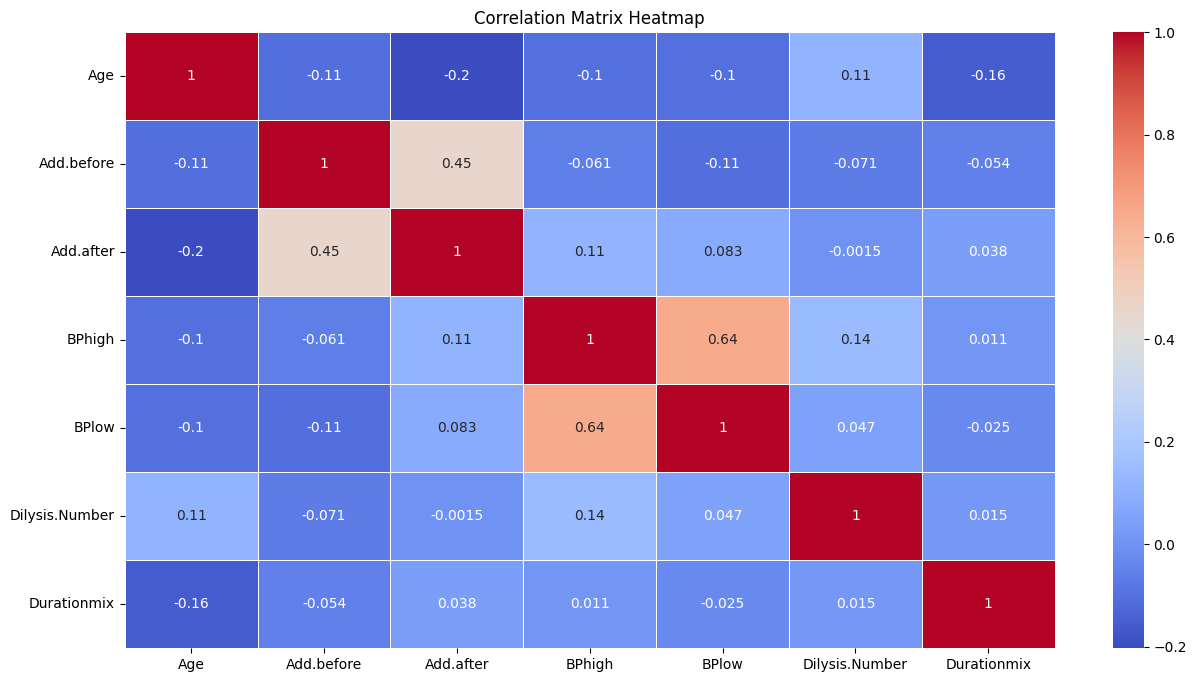

In [105]:
correlation_matrix(df_numeric_no_null)

###### don't give any idea : correlation_matrix(df_numeric_no_null)

### Categoroical Data

In [106]:
def check_corelation_category_col(col1,col2):
    # Create a contingency table
    contingency_table = pd.crosstab(col1, col2)

    # Perform the chi-squared test
    chi2, p, _, _ = chi2_contingency(contingency_table)
    return chi2,p

In [107]:
no_null_data = categorical_data.dropna()

In [108]:
correlation_category = pd.DataFrame()

In [109]:
for col1 in categorical_columns:
    p_value = []
    for col2 in categorical_columns:
        chi2,p = check_corelation_category_col(no_null_data[col1],no_null_data[col2])
        p_value.append(p)
    correlation_category[col1] = p_value

In [110]:
correlation_category = correlation_category.set_index(categorical_columns)
correlation_category.style.background_gradient(cmap="Blues")

In [111]:
## del Menopuase because same like Gender
## del HTN ////// DM
df_clean_coded = df_clean_coded.drop(['Menopuase','HTN'],axis=1)

In [112]:
correlation_category = correlation_category.drop(['Menopuase','HTN'],axis=1)
correlation_category = correlation_category.drop(['Menopuase','HTN'],axis=0)
correlation_category.style.background_gradient(cmap="Blues")

In [113]:
df_clean_coded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 466 entries, 89 to 1037
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             466 non-null    float64 
 1   Gender          466 non-null    category
 2   Add.before      408 non-null    float64 
 3   Add.after       407 non-null    float64 
 4   BPhigh          255 non-null    float64 
 5   BPlow           255 non-null    float64 
 6   DM              466 non-null    category
 7   Dialysis        282 non-null    category
 8   Dilysis.Number  268 non-null    float64 
 9   CathSide        284 non-null    category
 10  CathTipLoc      286 non-null    category
 11  Diagnosis       466 non-null    category
 12  Durationmix     334 non-null    float64 
dtypes: category(6), float64(7)
memory usage: 48.8 KB


#### calucate corr between category and numerical data

In [114]:
# Separate categorical and numerical columns
categorical_columns = df_clean_coded.select_dtypes(include=['category']).columns
numerical_columns = df_clean_coded.select_dtypes(include=['float64']).columns

In [115]:
def calucate_corr_between_category_and_numerical_data(df):
    df_no_null = df.dropna()
    correlation_category_numerical = pd.DataFrame()
    # Assumption(H0) is that FuelType and CarPrices are NOT correlated
    for col1 in categorical_columns:
        AnovaResults = []
        for col2 in numerical_columns:
            # We accept the Assumption(H0) only when P-Value &gt; 0.05
            CategoryGroupLists=df_no_null.groupby(col1)[col2].apply(list)
            AnovaResults.append(f_oneway(*CategoryGroupLists)[1])
        
        correlation_category_numerical[col1] = AnovaResults
    return correlation_category_numerical

In [116]:
correlation_category_numerical = calucate_corr_between_category_and_numerical_data(df_clean_coded)

In [117]:
correlation_category_numerical = correlation_category_numerical.set_index(numerical_columns)
correlation_category_numerical.style.background_gradient(cmap="Blues")

#### Fit missing value by KNN

In [118]:
knn_imputer = KNNImputer(n_neighbors=5)  # You can adjust n_neighbors as needed

In [119]:
data_fit_knn = pd.DataFrame(knn_imputer.fit_transform(df_clean_coded),columns=df_clean_coded.columns,index=df_clean_coded.index)

In [120]:
correlation_fited_category_numerical = calucate_corr_between_category_and_numerical_data(data_fit_knn)

### after fit by KNN

In [121]:
correlation_fited_category_numerical = correlation_fited_category_numerical.set_index(numerical_columns)
correlation_fited_category_numerical.style.background_gradient(cmap="Blues")

## Modle Selection

In [122]:
x = np.array(data_fit_knn.drop('Diagnosis',axis=1))
y = np.array(data_fit_knn['Diagnosis'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

### Balancing Data

In [123]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train))

Resampled dataset shape Counter({0.0: 266, 1.0: 266})


In [124]:
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.30, random_state=42)

### Normalizing Data

In [125]:
sc = StandardScaler()

In [126]:
X_train_sc = sc.fit_transform(X_train1)
X_val_sc = sc.transform(X_val)
x_test_sc= sc.transform(X_test)

In [127]:
X_train1.shape

(372, 12)

In [128]:
def ann_model(number_of_hidden_layer=1,
              number_of_neurons=50,
              lr=1):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=[12]))
    for hidden_layer in range(number_of_hidden_layer):
        model.add(keras.layers.Dense(number_of_neurons,activation='relu'))
    model.add(keras.layers.Dense(3,activation='softmax'))
    sgd = keras.optimizers.SGD(learning_rate=lr)
    # adam = keras.optimizers.Adam()
    model.compile(loss='sparse_categorical_crossentropy',optimizer=sgd,metrics=["accuracy"])
    return model

In [129]:
model_chechpoint_callback = keras.callbacks.ModelCheckpoint("model_checkpoint",
                                                            save_best_only=True)
earlystopping_callback = keras.callbacks.EarlyStopping(patience=10,
                                                       restore_best_weights=True)
tb_call_back = keras.callbacks.TensorBoard('tb_log')

In [130]:
keras_sk_classifier = keras.wrappers.scikit_learn.KerasRegressor(build_fn=ann_model)

C:\Users\Behnam\AppData\Local\Temp\ipykernel_7556\2230630598.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_sk_classifier = keras.wrappers.scikit_learn.KerasRegressor(build_fn=ann_model)


In [131]:
param_grid = {'number_of_hidden_layer':[2],
              'number_of_neurons':[10],
              'lr':[0.01]}

In [132]:
keras_sk_classifier_gs = GridSearchCV(keras_sk_classifier,param_grid,cv=3)

In [133]:
his = keras_sk_classifier_gs.fit((X_train_sc),
                         (y_train1),epochs=8,
                         validation_data=((X_val_sc),(y_val)),
                          callbacks=[model_chechpoint_callback,
                                     earlystopping_callback,
                                     tb_call_back])

Epoch 1/8
1/8 [==>...........................] - ETA: 3s - loss: 1.0345 - accuracy: 0.4375

INFO:tensorflow:Assets written to: model_checkpoint\assets


INFO:tensorflow:Assets written to: model_checkpoint\assets


8/8 [==============================] - 4s 435ms/step - loss: 1.1294 - accuracy: 0.3911 - val_loss: 1.0647 - val_accuracy: 0.5125
Epoch 2/8
1/8 [==>...........................] - ETA: 0s - loss: 1.1438 - accuracy: 0.4375

INFO:tensorflow:Assets written to: model_checkpoint\assets


INFO:tensorflow:Assets written to: model_checkpoint\assets


8/8 [==============================] - 2s 287ms/step - loss: 1.0931 - accuracy: 0.4435 - val_loss: 1.0346 - val_accuracy: 0.5500
Epoch 3/8
1/8 [==>...........................] - ETA: 0s - loss: 1.1298 - accuracy: 0.4062

INFO:tensorflow:Assets written to: model_checkpoint\assets


INFO:tensorflow:Assets written to: model_checkpoint\assets


8/8 [==============================] - 3s 362ms/step - loss: 1.0611 - accuracy: 0.4395 - val_loss: 1.0084 - val_accuracy: 0.5688
Epoch 4/8
1/8 [==>...........................] - ETA: 0s - loss: 1.0359 - accuracy: 0.4375

INFO:tensorflow:Assets written to: model_checkpoint\assets


INFO:tensorflow:Assets written to: model_checkpoint\assets


8/8 [==============================] - 2s 283ms/step - loss: 1.0326 - accuracy: 0.4637 - val_loss: 0.9849 - val_accuracy: 0.5813
Epoch 5/8
1/8 [==>...........................] - ETA: 0s - loss: 1.0108 - accuracy: 0.4688

INFO:tensorflow:Assets written to: model_checkpoint\assets


INFO:tensorflow:Assets written to: model_checkpoint\assets


8/8 [==============================] - 2s 341ms/step - loss: 1.0069 - accuracy: 0.4839 - val_loss: 0.9642 - val_accuracy: 0.5750
Epoch 6/8
1/8 [==>...........................] - ETA: 0s - loss: 0.9397 - accuracy: 0.5000

INFO:tensorflow:Assets written to: model_checkpoint\assets


INFO:tensorflow:Assets written to: model_checkpoint\assets


8/8 [==============================] - 3s 364ms/step - loss: 0.9843 - accuracy: 0.4919 - val_loss: 0.9457 - val_accuracy: 0.5688
Epoch 7/8
1/8 [==>...........................] - ETA: 0s - loss: 1.0194 - accuracy: 0.4688

INFO:tensorflow:Assets written to: model_checkpoint\assets


INFO:tensorflow:Assets written to: model_checkpoint\assets


8/8 [==============================] - 1s 119ms/step - loss: 0.9640 - accuracy: 0.4960 - val_loss: 0.9293 - val_accuracy: 0.5688
Epoch 8/8
1/8 [==>...........................] - ETA: 0s - loss: 0.9202 - accuracy: 0.4688

INFO:tensorflow:Assets written to: model_checkpoint\assets


INFO:tensorflow:Assets written to: model_checkpoint\assets


4/4 [==============================] - 0s 2ms/step - loss: 0.9349 - accuracy: 0.5161
Epoch 1/8
8/8 [==============================] - 2s 49ms/step - loss: 1.0169 - accuracy: 0.3992 - val_loss: 0.9882 - val_accuracy: 0.4062
Epoch 2/8
8/8 [==============================] - 0s 20ms/step - loss: 0.9956 - accuracy: 0.4234 - val_loss: 0.9716 - val_accuracy: 0.3875
Epoch 3/8
8/8 [==============================] - 0s 17ms/step - loss: 0.9764 - accuracy: 0.4153 - val_loss: 0.9567 - val_accuracy: 0.3812
Epoch 4/8
8/8 [==============================] - 0s 16ms/step - loss: 0.9590 - accuracy: 0.3992 - val_loss: 0.9432 - val_accuracy: 0.3750
Epoch 5/8
8/8 [==============================] - 0s 16ms/step - loss: 0.9431 - accuracy: 0.4032 - val_loss: 0.9306 - val_accuracy: 0.3812
Epoch 6/8
8/8 [==============================] - 0s 17ms/step - loss: 0.9280 - accuracy: 0.4032 - val_loss: 0.9190 - val_accuracy: 0.4000
Epoch 7/8
1/8 [==>...........................] - ETA: 0s - loss: 0.9036 - accuracy: 0.4

INFO:tensorflow:Assets written to: model_checkpoint\assets


INFO:tensorflow:Assets written to: model_checkpoint\assets


8/8 [==============================] - 1s 168ms/step - loss: 0.9143 - accuracy: 0.4073 - val_loss: 0.9083 - val_accuracy: 0.4250
Epoch 8/8
1/8 [==>...........................] - ETA: 0s - loss: 0.9216 - accuracy: 0.4062

INFO:tensorflow:Assets written to: model_checkpoint\assets


INFO:tensorflow:Assets written to: model_checkpoint\assets


4/4 [==============================] - 0s 3ms/step - loss: 0.8643 - accuracy: 0.5000
Epoch 1/8
8/8 [==============================] - 1s 92ms/step - loss: 1.3501 - accuracy: 0.1653 - val_loss: 1.2382 - val_accuracy: 0.2562
Epoch 2/8
8/8 [==============================] - 0s 20ms/step - loss: 1.2498 - accuracy: 0.2339 - val_loss: 1.1571 - val_accuracy: 0.3625
Epoch 3/8
8/8 [==============================] - 0s 17ms/step - loss: 1.1728 - accuracy: 0.3024 - val_loss: 1.0956 - val_accuracy: 0.4062
Epoch 4/8
8/8 [==============================] - 0s 16ms/step - loss: 1.1135 - accuracy: 0.3710 - val_loss: 1.0477 - val_accuracy: 0.4437
Epoch 5/8
8/8 [==============================] - 0s 17ms/step - loss: 1.0670 - accuracy: 0.4153 - val_loss: 1.0092 - val_accuracy: 0.4938
Epoch 6/8
8/8 [==============================] - 0s 16ms/step - loss: 1.0282 - accuracy: 0.4677 - val_loss: 0.9784 - val_accuracy: 0.5312
Epoch 7/8
8/8 [==============================] - 0s 17ms/step - loss: 0.9965 - accuracy

####################################################################################################

In [134]:
his.best_estimator_.model.evaluate(x_test_sc,y_test)

5/5 [==============================] - 0s 2ms/step - loss: 0.9583 - accuracy: 0.5143


[0.958339273929596, 0.5142857432365417]

################################################################